In [ ]:
%pip install torch torchvision torchaudio pandas matplotlib scikit-learn pyarrow
import sys
import os
from pathlib import Path


notebook_dir = os.getcwd()

_dir = Path(notebook_dir).resolve()
while _dir != _dir.parent:
    if (_dir / "src").is_dir() and (_dir / "data").is_dir():
        project_root = str(_dir)
        break
    _dir = _dir.parent
else:
   
    project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add project root to system path
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"Project root: {project_root}")

Note: you may need to restart the kernel to use updated packages.
Project root: C:\Users\Yizi\Desktop\EV Battery Predictor



[notice] A new release of pip available: 22.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os
import importlib
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt


import src.utils.config
importlib.reload(src.utils.config)
from src.utils.config import TrainConfig, FeatureConfig

import src.models.dataset
importlib.reload(src.models.dataset)
from src.models.dataset import BatteryDataset

# Reload architecture module
import src.models.architecture
importlib.reload(src.models.architecture)
from src.models.architecture import LSTMRegressor

In [3]:
# Verify configuration values
cfg = TrainConfig()
feat_cfg = FeatureConfig()
print("TrainConfig:", cfg.__dict__)
print("Feature cols:", feat_cfg.feature_cols)
print("Target col:", feat_cfg.target_col)

TrainConfig: {'train_batteries': ('B0005', 'B0006', 'B0007'), 'val_batteries': ('B0018',), 'test_batteries': ('B0018',), 'seq_length': 50, 'input_size': 6, 'hidden_size_1': 64, 'hidden_size_2': 32, 'num_layers': 2, 'dropout': 0.3, 'epochs': 100, 'batch_size': 16, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'patience': 20, 'seed': 42}
Feature cols: ('max_temperature', 'avg_voltage_load', 'time_to_discharge', 'min_voltage_load', 'avg_temperature', 'cycle_index')
Target col: discharge_capacity


Loaded 636 rows from C:\Users\Yizi\Desktop\EV Battery Predictor\data/processed/final_battery_features.csv
Columns: ['battery_id', 'cycle_index', 'type', 'discharge_capacity', 'soh', 'avg_voltage_load', 'min_voltage_load', 'max_temperature', 'avg_temperature', 'time_to_discharge', 'internal_resistance', 're', 'rct']

Train: 504 rows ('B0005', 'B0006', 'B0007')
Val:   132 rows ('B0018',)
Test:  132 rows ('B0018',)
Samples -> Train: 354, Val: 82, Test: 82
Device: cpu | Model parameters: 32,065
Epoch [ 10/100] | Train: 0.025888 | Val: 0.001530 | LR: 1.00e-03
Epoch [ 20/100] | Train: 0.014078 | Val: 0.000263 | LR: 1.00e-03
Epoch [ 30/100] | Train: 0.010747 | Val: 0.000670 | LR: 5.00e-04
Epoch [ 40/100] | Train: 0.008503 | Val: 0.000404 | LR: 2.50e-04

Early stopping at epoch 47 (no improvement for 20 epochs)

Best Val Loss: 0.000184


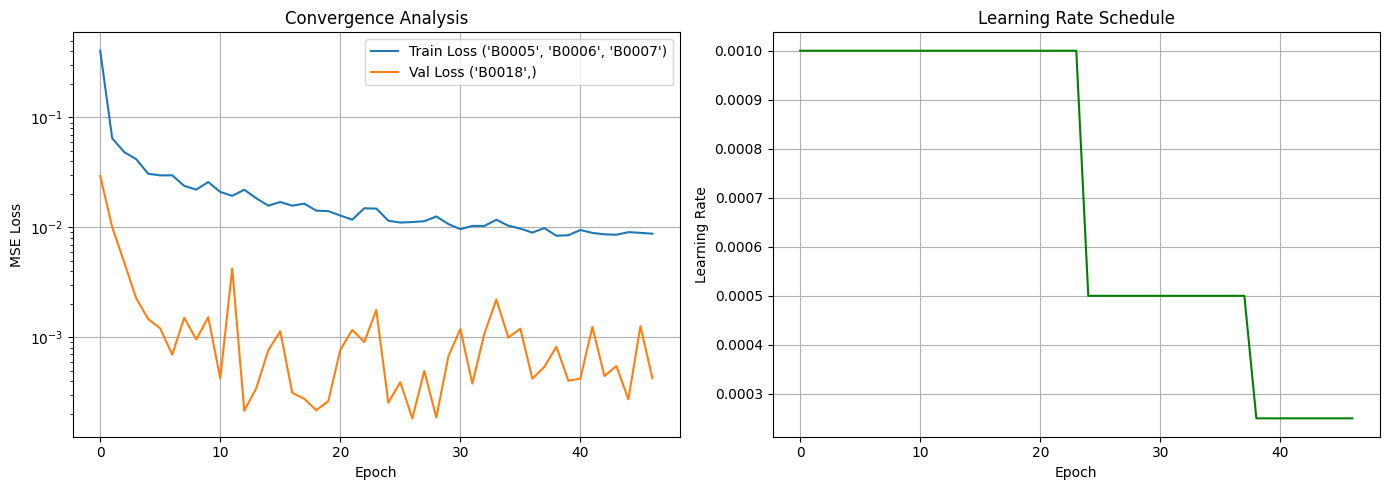

In [ ]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load Data 
DATA_PATH = os.path.join(project_root, 'data/processed/final_battery_features.csv')
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df)} rows from {DATA_PATH}")
print(f"Columns: {list(df.columns)}")

# Split by battery — matches TrainConfig ──
cfg = TrainConfig()
feat_cfg = FeatureConfig()

train_df = df[df['battery_id'].isin(cfg.train_batteries)].copy()  # B0005, B0006, B0007
val_df   = df[df['battery_id'].isin(cfg.val_batteries)].copy()    # B0018
test_df  = df[df['battery_id'].isin(cfg.test_batteries)].copy()   # B0018

# MinMaxScaler [0,1] — better cross-battery normalization

feature_cols = list(feat_cfg.feature_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols]   = scaler.transform(val_df[feature_cols])
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

print(f"\nTrain: {len(train_df)} rows {cfg.train_batteries}")
print(f"Val:   {len(val_df)} rows {cfg.val_batteries}")
print(f"Test:  {len(test_df)} rows {cfg.test_batteries}")

# Create Datasets 
train_ds = BatteryDataset(train_df, seq_length=cfg.seq_length, noise_std=0.02)
val_ds   = BatteryDataset(val_df,   seq_length=cfg.seq_length)
test_ds  = BatteryDataset(test_df,  seq_length=cfg.seq_length)

print(f"Samples -> Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=cfg.batch_size, shuffle=False)

# Build Model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMRegressor(
    input_size=cfg.input_size,   # 3
    hidden_1=cfg.hidden_size_1,  # 64
    hidden_2=cfg.hidden_size_2,  # 64
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Device: {device} | Model parameters: {n_params:,}")

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=cfg.learning_rate,
    weight_decay=cfg.weight_decay
)
criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

# Training Loop with Early Stopping ───────
os.makedirs(os.path.join(project_root, 'checkpoints'), exist_ok=True)

history = {'train': [], 'val': [], 'lr': []}
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(cfg.epochs):
    # Train 
    model.train()
    train_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    # Validate 
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            val_loss += criterion(output, y).item()

    avg_train = train_loss / len(train_loader)
    avg_val   = val_loss / len(val_loader)
    current_lr = optimizer.param_groups[0]['lr']

    history['train'].append(avg_train)
    history['val'].append(avg_val)
    history['lr'].append(current_lr)

    scheduler.step(avg_val)

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(project_root, 'checkpoints/best_model.pth'))
    else:
        patience_counter += 1

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1:>3}/{cfg.epochs}] | Train: {avg_train:.6f} | Val: {avg_val:.6f} | LR: {current_lr:.2e}")

    if patience_counter >= cfg.patience:
        print(f"\nEarly stopping at epoch {epoch+1} (no improvement for {cfg.patience} epochs)")
        break

print(f"\nBest Val Loss: {best_val_loss:.6f}")

# Convergence Plot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history['train'], label=f'Train Loss {cfg.train_batteries}')
ax1.plot(history['val'],   label=f'Val Loss {cfg.val_batteries}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_yscale('log')
ax1.set_title('Convergence Analysis')
ax1.legend()
ax1.grid(True)

ax2.plot(history['lr'], color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate Schedule')
ax2.grid(True)

plt.tight_layout()
plt.show()

Loaded best checkpoint from C:\Users\Yizi\Desktop\EV Battery Predictor\checkpoints/best_model.pth

Split                                MAE (SOH)  RMSE (SOH)       R²   MAE (Ah)   RMSE (Ah)
--------------------------------------------------------------------------------
Train ('B0005', 'B0006', 'B0007')       0.0380      0.0402   0.6787    0.0760 Ah    0.0804 Ah
Val ('B0018',)                          0.0105      0.0143   0.8874    0.0210 Ah    0.0286 Ah

Interpretation: MAE (SOH) of 0.01 = 1% SOH error = 0.020 Ah capacity error


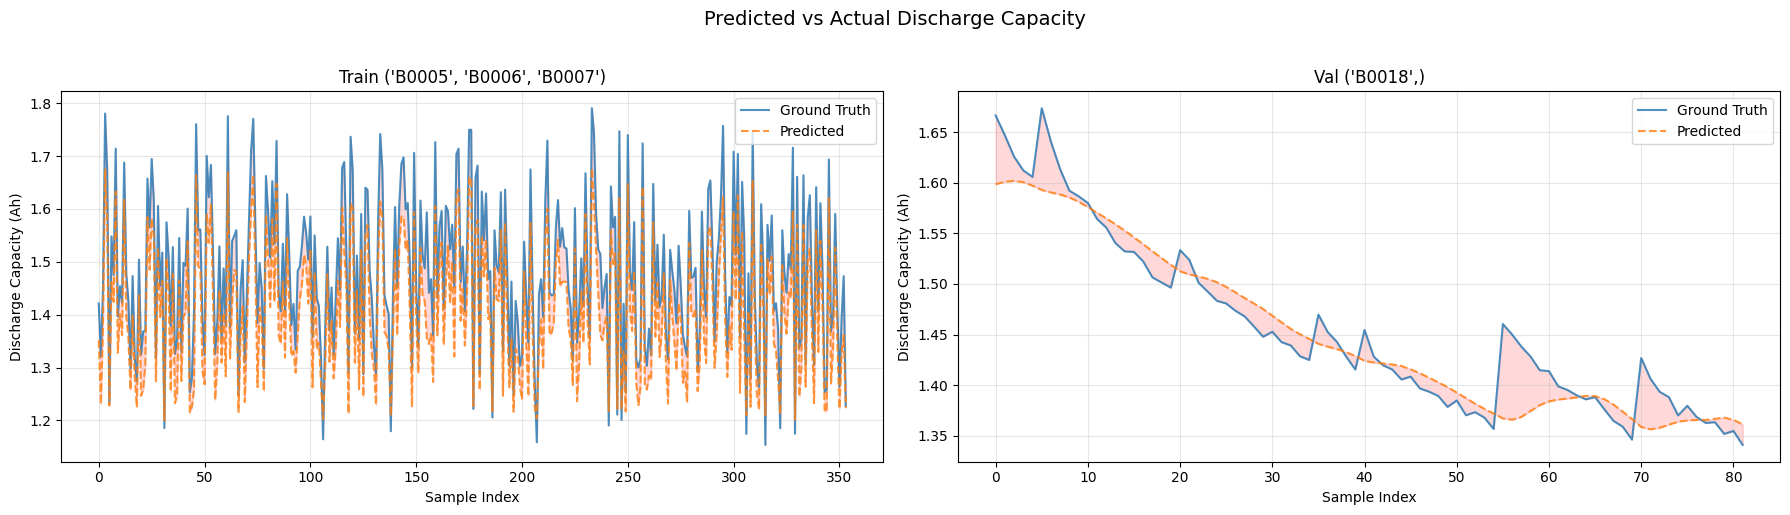

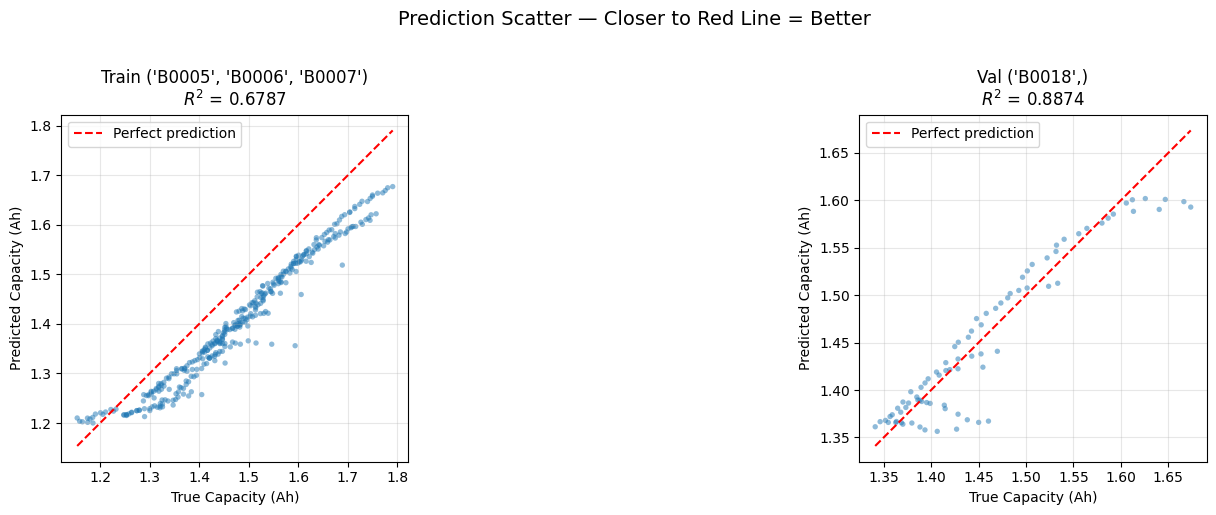

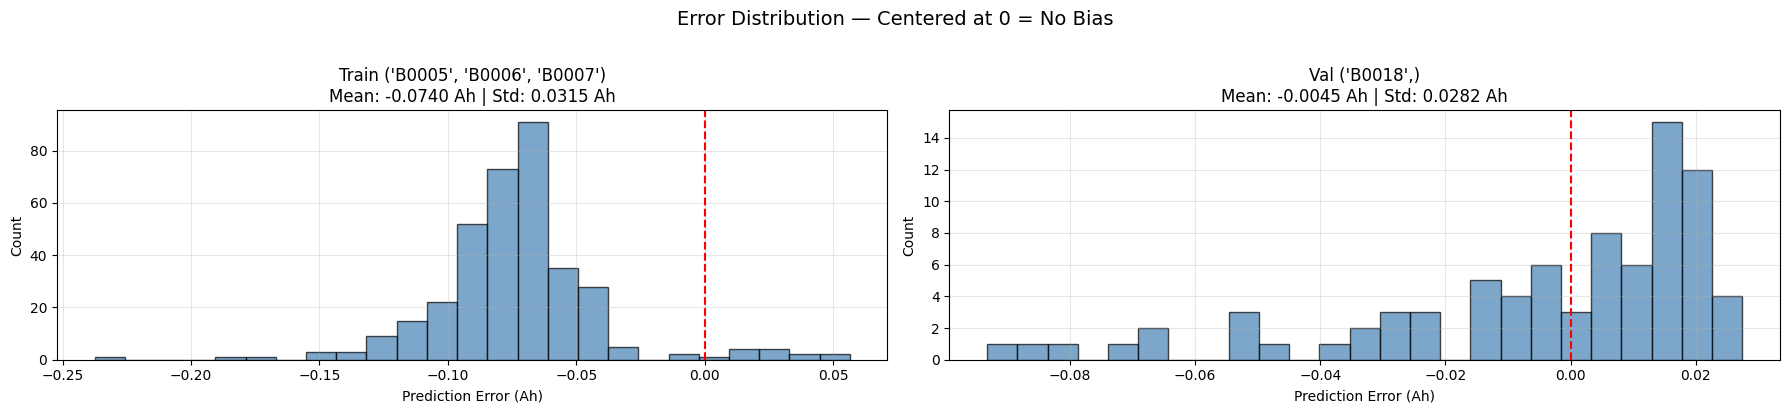

In [5]:
# ══════════════════════════════════════════════════════════════════════════════
# 8. Real-World Prediction Accuracy — SOH & Capacity
# ══════════════════════════════════════════════════════════════════════════════
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

RATED_CAPACITY = feat_cfg.rated_capacity  # 2.0 Ah

# ── 8a. Load best checkpoint ─────────────────────────────────────────────────
ckpt_path = os.path.join(project_root, 'checkpoints/best_model.pth')
model.load_state_dict(torch.load(ckpt_path, map_location=device, weights_only=True))
model.eval()
print(f"Loaded best checkpoint from {ckpt_path}\n")

# ── 8b. Collect predictions for all splits ────────────────────────────────────
def collect_predictions(loader, device):
    """Run inference and return (y_true, y_pred) as numpy arrays."""
    all_true, all_pred = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            pred = model(X)
            all_true.append(y.numpy())
            all_pred.append(pred.cpu().numpy())
    return np.concatenate(all_true), np.concatenate(all_pred)

splits = {
    f'Train {cfg.train_batteries}': train_loader,
    f'Val {cfg.val_batteries}':     val_loader,
}

results = {}
for name, loader in splits.items():
    y_true, y_pred = collect_predictions(loader, device)
    results[name] = (y_true, y_pred)

# ── 8c. Metrics Table ────────────────────────────────────────────────────────
print("=" * 80)
print(f"{'Split':<35} {'MAE (SOH)':>10} {'RMSE (SOH)':>11} {'R²':>8} {'MAE (Ah)':>10} {'RMSE (Ah)':>11}")
print("-" * 80)

for name, (y_true, y_pred) in results.items():
    mae_soh  = mean_absolute_error(y_true, y_pred)
    rmse_soh = root_mean_squared_error(y_true, y_pred)
    r2       = r2_score(y_true, y_pred)

    # Convert SOH to real capacity: capacity = SOH x rated_capacity
    mae_ah  = mae_soh * RATED_CAPACITY
    rmse_ah = rmse_soh * RATED_CAPACITY

    print(f"{name:<35} {mae_soh:>10.4f} {rmse_soh:>11.4f} {r2:>8.4f} {mae_ah:>9.4f} Ah {rmse_ah:>9.4f} Ah")

print("=" * 80)
print(f"\nInterpretation: MAE (SOH) of 0.01 = 1% SOH error = {0.01 * RATED_CAPACITY:.3f} Ah capacity error")

# ── 8d. Prediction vs Ground Truth Plots ─────────────────────────────────────
n_splits = len(results)
fig, axes = plt.subplots(1, n_splits, figsize=(9 * n_splits, 5))
if n_splits == 1:
    axes = [axes]

for ax, (name, (y_true, y_pred)) in zip(axes, results.items()):
    cap_true = y_true * RATED_CAPACITY
    cap_pred = y_pred * RATED_CAPACITY

    ax.plot(cap_true, label='Ground Truth', linewidth=1.5, alpha=0.8)
    ax.plot(cap_pred, label='Predicted', linewidth=1.5, alpha=0.8, linestyle='--')
    ax.fill_between(range(len(cap_true)), cap_true, cap_pred, alpha=0.15, color='red')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Discharge Capacity (Ah)')
    ax.set_title(name)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Predicted vs Actual Discharge Capacity', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ── 8e. Scatter Plot — Predicted vs True ──────────────────────────────────────
fig, axes = plt.subplots(1, n_splits, figsize=(9 * n_splits, 5))
if n_splits == 1:
    axes = [axes]

for ax, (name, (y_true, y_pred)) in zip(axes, results.items()):
    cap_true = y_true * RATED_CAPACITY
    cap_pred = y_pred * RATED_CAPACITY

    ax.scatter(cap_true, cap_pred, alpha=0.5, s=15, edgecolors='none')

    lims = [min(cap_true.min(), cap_pred.min()), max(cap_true.max(), cap_pred.max())]
    ax.plot(lims, lims, 'r--', linewidth=1.5, label='Perfect prediction')

    r2 = r2_score(y_true, y_pred)
    ax.set_xlabel('True Capacity (Ah)')
    ax.set_ylabel('Predicted Capacity (Ah)')
    ax.set_title(f'{name}\n$R^2$ = {r2:.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.suptitle('Prediction Scatter — Closer to Red Line = Better', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ── 8f. Error Distribution ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, n_splits, figsize=(9 * n_splits, 4))
if n_splits == 1:
    axes = [axes]

for ax, (name, (y_true, y_pred)) in zip(axes, results.items()):
    errors_ah = (y_pred - y_true) * RATED_CAPACITY
    ax.hist(errors_ah, bins=25, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(0, color='red', linestyle='--', linewidth=1.5)
    ax.set_xlabel('Prediction Error (Ah)')
    ax.set_ylabel('Count')
    ax.set_title(f'{name}\nMean: {errors_ah.mean():.4f} Ah | Std: {errors_ah.std():.4f} Ah')
    ax.grid(True, alpha=0.3)

plt.suptitle('Error Distribution — Centered at 0 = No Bias', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()